In [1]:
import pandas as pd
import numpy
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
import sklearn.utils
from sklearn.model_selection import StratifiedGroupKFold

In [2]:
df = pd.read_csv('./BBBP_extend.csv')


In [3]:

mol_list = []
for smi in df.smiles:
    mol_list.append(Chem.MolFromSmiles(smi))

scaffolds = {}
clusters_list =[]

idx = 1

[11:01:16] WARNING: not removing hydrogen atom without neighbors
[11:01:16] WARNING: not removing hydrogen atom without neighbors
[11:01:16] WARNING: not removing hydrogen atom without neighbors
[11:01:16] WARNING: not removing hydrogen atom without neighbors
[11:01:16] WARNING: not removing hydrogen atom without neighbors
[11:01:16] WARNING: not removing hydrogen atom without neighbors
[11:01:16] WARNING: not removing hydrogen atom without neighbors
[11:01:16] WARNING: not removing hydrogen atom without neighbors
[11:01:16] WARNING: not removing hydrogen atom without neighbors
[11:01:16] WARNING: not removing hydrogen atom without neighbors
[11:01:16] WARNING: not removing hydrogen atom without neighbors
[11:01:16] WARNING: not removing hydrogen atom without neighbors
[11:01:16] WARNING: not removing hydrogen atom without neighbors
[11:01:16] WARNING: not removing hydrogen atom without neighbors
[11:01:16] WARNING: not removing hydrogen atom without neighbors
[11:01:16] WARNING: not r

In [3]:
from collections import defaultdict
import logging
import random
from typing import Dict, List, Set, Tuple, Union

from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from tqdm import tqdm
import numpy as np
# from numba import jit
from time import time
import pdb

from .data import MoleculeDataset
from rdkit.ML.Cluster import Butina
from rdkit.Chem import AllChem
from rdkit import DataStructs


def generate_scaffold(mol: Union[str, Chem.Mol], include_chirality: bool = False) -> str:
    """
    Compute the Bemis-Murcko scaffold for a SMILES string.

    :param mol: A smiles string or an RDKit molecule.
    :param include_chirality: Whether to include chirality.
    :return:
    """
    mol = Chem.MolFromSmiles(mol) if type(mol) == str else mol
    scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=include_chirality)
    return scaffold


def scaffold_to_smiles(mols: Union[List[str], List[Chem.Mol]],
                       use_indices: bool = False) -> Dict[str, Union[Set[str], Set[int]]]:
    """
    Computes scaffold for each smiles string and returns a mapping from scaffolds to sets of smiles.

    :param mols: A list of smiles strings or RDKit molecules.
    :param use_indices: Whether to map to the smiles' index in all_smiles rather than mapping
    to the smiles string itself. This is necessary if there are duplicate smiles.
    :return: A dictionary mapping each unique scaffold to all smiles (or smiles indices) which have that scaffold.
    """
    scaffolds = defaultdict(set)
    for i, mol in tqdm(enumerate(mols), total=len(mols)):
        scaffold = generate_scaffold(mol)
        if use_indices:
            scaffolds[scaffold].add(i)
        else:
            scaffolds[scaffold].add(mol)
    return scaffolds


def scaffold_split(data: MoleculeDataset,
                   sizes: Tuple[float, float, float] = (0.8, 0.1, 0.1),
                   balanced: bool = False,
                   seed: int = 0,
                   logger: logging.Logger = None) -> Tuple[MoleculeDataset,
                                                           MoleculeDataset,
                                                           MoleculeDataset]:
    """
    Split a dataset by scaffold so that no molecules sharing a scaffold are in the same split.

    :param data: A MoleculeDataset.
    :param sizes: A length-3 tuple with the proportions of data in the
    train, validation, and test sets.
    :param balanced: Try to balance sizes of scaffolds in each set, rather than just putting smallest in test set.
    :param seed: Seed for shuffling when doing balanced splitting.
    :param logger: A logger.
    :return: A tuple containing the train, validation, and test splits of the data.
    """
    assert sum(sizes) == 1

    # Split
    train_size, val_size, test_size = sizes[0] * len(data), sizes[1] * len(data), sizes[2] * len(data)
    train, val, test = [], [], []
    train_scaffold_count, val_scaffold_count, test_scaffold_count = 0, 0, 0

    # Map from scaffold to index in the data
    scaffold_to_indices = scaffold_to_smiles(data.mols(), use_indices=True)

    if balanced:  # Put stuff that's bigger than half the val/test size into train, rest just order randomly
        index_sets = list(scaffold_to_indices.values())
        big_index_sets = []
        small_index_sets = []
        for index_set in index_sets:
            if len(index_set) > val_size / 2 or len(index_set) > test_size / 2:
                big_index_sets.append(index_set)
            else:
                small_index_sets.append(index_set)
        random.seed(seed)
        random.shuffle(big_index_sets)
        random.shuffle(small_index_sets)
        index_sets = big_index_sets + small_index_sets
    else:  # Sort from largest to smallest scaffold sets
        index_sets = sorted(list(scaffold_to_indices.values()),
                            key=lambda index_set: len(index_set),
                            reverse=True)

    for index_set in index_sets:
        if len(train) + len(index_set) <= train_size:
            train += index_set
            train_scaffold_count += 1
        elif len(val) + len(index_set) <= val_size:
            val += index_set
            val_scaffold_count += 1
        else:
            test += index_set
            test_scaffold_count += 1

    if logger is not None:
        logger.debug(f'Total scaffolds = {len(scaffold_to_indices):,} | '
                     f'train scaffolds = {train_scaffold_count:,} | '
                     f'val scaffolds = {val_scaffold_count:,} | '
                     f'test scaffolds = {test_scaffold_count:,}')
    
    log_scaffold_stats(data, index_sets, logger=logger)

    # Map from indices to data
    train = [data[i] for i in train]
    val = [data[i] for i in val]
    test = [data[i] for i in test]

    return MoleculeDataset(train), MoleculeDataset(val), MoleculeDataset(test)

def log_scaffold_stats(data: MoleculeDataset,
                       index_sets: List[Set[int]],
                       num_scaffolds: int = 10,
                       num_labels: int = 20,
                       logger: logging.Logger = None) -> List[Tuple[List[float], List[int]]]:
    """
    Logs and returns statistics about counts and average target values in molecular scaffolds.

    :param data: A MoleculeDataset.
    :param index_sets: A list of sets of indices representing splits of the data.
    :param num_scaffolds: The number of scaffolds about which to display statistics.
    :param num_labels: The number of labels about which to display statistics.
    :param logger: A Logger.
    :return: A list of tuples where each tuple contains a list of average target values
    across the first num_labels labels and a list of the number of non-zero values for
    the first num_scaffolds scaffolds, sorted in decreasing order of scaffold frequency.
    """
    # print some statistics about scaffolds
    target_avgs = []
    counts = []
    for index_set in index_sets:
        data_set = [data[i] for i in index_set]
        targets = [d.targets for d in data_set]
        targets = np.array(targets, dtype=np.float)
        target_avgs.append(np.nanmean(targets, axis=0))
        counts.append(np.count_nonzero(~np.isnan(targets), axis=0))
    stats = [(target_avgs[i][:num_labels], counts[i][:num_labels]) for i in range(min(num_scaffolds, len(target_avgs)))]

    if logger is not None:
        logger.debug('Label averages per scaffold, in decreasing order of scaffold frequency,'
                     f'capped at {num_scaffolds} scaffolds and {num_labels} labels: {stats}')

    return stats


def cluster_split(data: MoleculeDataset,
                   sizes: Tuple[float, float, float] = (0.8, 0.1, 0.1),
                   balanced: bool = False,
                   seed: int = 0,
                   logger: logging.Logger = None) -> Tuple[MoleculeDataset,
                                                           MoleculeDataset,
                                                           MoleculeDataset]:
    """
    Split a dataset by cluster so that no molecules in a same cluster are in the same split.

    :param data: A MoleculeDataset.
    :param sizes: A length-3 tuple with the proportions of data in the
    train, validation, and test sets.
    :param balanced: Try to balance sizes of clusters in each set, rather than just putting smallest in test set.
    :param seed: Seed for shuffling when doing balanced splitting.
    :param logger: A logger.
    :return: A tuple containing the train, validation, and test splits of the data.
    """
    assert sum(sizes) == 1

    # Split
    train_size, val_size, test_size = sizes[0] * len(data), sizes[1] * len(data), sizes[2] * len(data)
    train, val, test = [], [], []
    train_cluster_count, val_cluster_count, test_cluster_count = 0, 0, 0

    # Map from cluster to index in the data
    fingerprints = [AllChem.GetMorganFingerprint(m,2) for m in data.mols()]
    dists = []
    nfps = len(fingerprints)
    for i in tqdm(range(nfps)):
        if i == 0:
            continue
        sims = DataStructs.BulkTanimotoSimilarity(fingerprints[i], fingerprints[:i])
        dists.extend([(1 - x) for x in sims])
    cluster_to_indices = Butina.ClusterData(dists, nfps, 0.4, isDistData=True)
    cluster_to_indices_list = [list(x) for x in cluster_to_indices]

    if balanced:  # Put stuff that's bigger than half the val/test size into train, rest just order randomly
        index_sets = cluster_to_indices_list
        big_index_sets = []
        small_index_sets = []
        for index_set in index_sets:
            if len(index_set) > val_size / 2 or len(index_set) > test_size / 2:
                big_index_sets.append(index_set)
            else:
                small_index_sets.append(index_set)
        random.seed(seed)
        random.shuffle(big_index_sets)
        random.shuffle(small_index_sets)
        index_sets = big_index_sets + small_index_sets
    else:  # Sort from largest to smallest cluster sets
        index_sets = sorted(list(cluster_to_indices.values()),
                            key=lambda index_set: len(index_set),
                            reverse=True)

    for index_set in index_sets:
        if len(train) + len(index_set) <= train_size:
            train += index_set
            train_cluster_count += 1
        elif len(val) + len(index_set) <= val_size:
            val += index_set
            val_cluster_count += 1
        else:
            test += index_set
            test_cluster_count += 1

    if logger is not None:
        logger.debug(f'Total clusters = {len(cluster_to_indices):,} | '
                     f'train clusters = {train_cluster_count:,} | '
                     f'val clusters = {val_cluster_count:,} | '
                     f'test clusters = {test_cluster_count:,}')
        
    log_cluster_stats(data, index_sets, logger=logger)

    # Map from indices to data
    train = [data[i] for i in train]
    val = [data[i] for i in val]
    test = [data[i] for i in test]

    return MoleculeDataset(train), MoleculeDataset(val), MoleculeDataset(test)


def log_cluster_stats(data: MoleculeDataset,
                       index_sets: List[Set[int]],
                       num_clusters: int = 10,
                       num_labels: int = 20,
                       logger: logging.Logger = None) -> List[Tuple[List[float], List[int]]]:
    """
    Logs and returns statistics about counts and average target values in molecular clusters.

    :param data: A MoleculeDataset.
    :param index_sets: A list of sets of indices representing splits of the data.
    :param num_clusters: The number of clusters about which to display statistics.
    :param num_labels: The number of labels about which to display statistics.
    :param logger: A Logger.
    :return: A list of tuples where each tuple contains a list of average target values
    across the first num_labels labels and a list of the number of non-zero values for
    the first num_clusters clusters, sorted in decreasing order of cluster frequency.
    """
    # print some statistics about clusters
    target_avgs = []
    counts = []
    for index_set in index_sets:
        data_set = [data[i] for i in index_set]
        targets = [d.targets for d in data_set]
        targets = np.array(targets, dtype=np.float)
        target_avgs.append(np.nanmean(targets, axis=0))
        counts.append(np.count_nonzero(~np.isnan(targets), axis=0))
    stats = [(target_avgs[i][:num_labels], counts[i][:num_labels]) for i in range(min(num_clusters, len(target_avgs)))]

    if logger is not None:
        logger.debug('Label averages per cluster, in decreasing order of cluster frequency,'
                     f'capped at {num_clusters} clusters and {num_labels} labels: {stats}')

    return stats

ImportError: attempted relative import with no known parent package

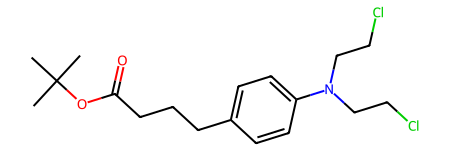

In [4]:
mol_list[1]

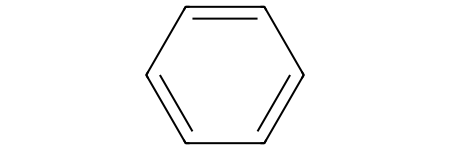

In [5]:
MurckoScaffold.GetScaffoldForMol(mol_list[1])

In [6]:

for mol in mol_list:
    print(mol)
    scaffold_smi =  MurckoScaffold.GetScaffoldForMol(mol)
    if scaffold_smi not in scaffolds.keys():
        scaffolds[scaffold_smi] = idx
        idx+=1
       
    cluster_id = scaffolds[scaffold_smi]
    clusters_list.append(cluster_id)
   



In [7]:
df['Group'] = clusters_list
df = sklearn.utils.shuffle(df,random_state=42).reset_index(drop=True)

df.to_csv('./extend_dataset/BBBP_extend_group.csv',index=False)

In [8]:
df_not_na=df[df["A1.0"].isna()]

In [9]:

from signaturizer import Signaturizer
sign = Signaturizer('A1')
import numpy as np
np.bool = np.bool_

2023-09-29 11:01:20.156413: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 11:01:21.530736: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-09-29 11:01:25.040694: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38400 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2023-09-29 11:01:25.042619: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38400 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


In [10]:
not_na_A1 = sign.predict(df_not_na["smiles"])
# df_not_na_A1
df_not_na_A1_np=not_na_A1.signature

Parsing SMILES: 850it [00:00, 6735.60it/s]
Generating signatures:   0%|                              | 0/7 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


2023-09-29 11:01:27.099242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Generating signatures:  14%|███▏                  | 1/7 [00:00<00:04,  1.21it/s]

1/1 [==============================] - 0s 19ms/step


Generating signatures:  29%|██████▎               | 2/7 [00:01<00:02,  2.23it/s]

1/1 [==============================] - 0s 19ms/step


Generating signatures:  43%|█████████▍            | 3/7 [00:01<00:01,  3.04it/s]

1/1 [==============================] - 0s 19ms/step


Generating signatures:  57%|████████████▌         | 4/7 [00:01<00:00,  3.65it/s]

1/1 [==============================] - 0s 19ms/step


Generating signatures:  71%|███████████████▋      | 5/7 [00:01<00:00,  3.13it/s]

1/1 [==============================] - 0s 19ms/step


Generating signatures:  86%|██████████████████▊   | 6/7 [00:01<00:00,  3.64it/s]

1/1 [==============================] - 0s 44ms/step


Generating signatures: 100%|██████████████████████| 7/7 [00:02<00:00,  3.20it/s]


In [11]:
df_na=pd.DataFrame(df_not_na_A1_np, columns=list(df.columns)[2:130])

In [12]:
df_na_index_in_df=df_not_na["smiles"].reset_index()

In [13]:
df_na

,A1.0,A1.1,A1.2,A1.3,A1.4,A1.5,A1.6,A1.7,A1.8,A1.9,...,A1.118,A1.119,A1.120,A1.121,A1.122,A1.123,A1.124,A1.125,A1.126,A1.127
0,0.096841,-0.098965,0.094675,0.093000,-0.097822,0.098495,0.098698,0.088351,0.087489,0.066744,...,0.098934,-0.076089,0.098872,-0.098059,-0.085050,-0.098963,-0.079267,0.097879,-0.097343,0.042199
1,-0.102891,-0.094094,0.097489,-0.105358,-0.101633,0.103867,0.105476,-0.079065,0.105545,-0.029111,...,0.000704,-0.014743,0.100301,0.078206,-0.077028,0.087733,-0.105539,0.105575,-0.096165,0.031007
2,0.094631,-0.096577,-0.096595,0.095854,-0.096600,-0.091264,-0.096477,-0.096600,0.090719,-0.096597,...,-0.096234,0.092659,0.092130,-0.096596,-0.096592,0.072019,-0.083774,-0.091713,-0.096465,-0.095937
3,-0.107333,-0.098741,-0.097410,0.076656,-0.013641,0.010725,0.110931,-0.111803,-0.069213,0.052715,...,-0.102550,-0.076146,0.112492,0.101139,-0.112560,0.023023,-0.114997,-0.103935,-0.036661,-0.099352
4,0.084123,-0.101748,-0.101498,-0.024821,-0.101776,-0.034897,-0.091437,-0.100548,0.086626,-0.101039,...,-0.081816,0.006937,0.082620,-0.100769,-0.100992,0.086411,-0.090699,-0.099391,-0.101392,-0.101572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
845,-0.102981,0.009447,-0.105207,0.106139,-0.106158,-0.086838,-0.106157,-0.106137,0.087140,-0.106043,...,0.095349,0.092822,0.106019,-0.105433,-0.100459,-0.095287,-0.104244,0.103488,-0.105676,0.034980
846,-0.044171,0.085859,0.064021,-0.106861,-0.106049,0.097186,0.102515,-0.099199,0.072278,-0.101008,...,-0.101978,-0.102672,0.073811,-0.085265,-0.023466,-0.092185,-0.106622,0.106850,0.071629,0.085853
847,-0.067531,-0.095985,-0.096370,0.095128,-0.096402,0.008348,0.043113,-0.096402,-0.094885,-0.096402,...,-0.096399,0.096381,-0.091911,-0.070579,-0.096379,0.096182,0.095790,0.082922,-0.096002,-0.091929
848,0.055983,-0.095626,-0.095639,0.095637,-0.095640,-0.095640,-0.095561,-0.095640,0.095640,-0.058639,...,0.095629,-0.092355,0.095631,-0.080586,0.025873,0.015530,-0.095282,0.056434,-0.095640,-0.093399


In [14]:
for i in range(df_na.shape[0]):
    df_na_index=df_na_index_in_df["index"]
    df.iloc[df_na_index,2:130]=df_na.iloc[i,:]



    

In [15]:
df.to_csv('./extend_dataset/BBBP_extend_v2.csv',index=False)

In [16]:
df=pd.read_csv("./extend_dataset/BBBP_extend_v2.csv")

In [17]:
X=df.iloc[:,2:3202]
y=df["p_np"]
groups=df['Group']

In [17]:
#########################
# 自定义，按组划分
cv_group = StratifiedGroupKFold(n_splits=5).split(X, y, groups=groups)
for i,(train_index, test_index) in zip(range(5),cv_group):
    
    
        
    
        X_train, y_train, X_test, y_test = X.iloc[train_index,], y.iloc[train_index,], X.iloc[test_index,], y.iloc[test_index,]
        groups_train, groups_test = groups.iloc[train_index], groups.iloc[test_index]
        train = pd.concat([X_train,y_train,groups_train],axis=1)
        test = pd.concat([X_test,y_test,groups_test],axis=1)
        
        
        
        
        filename_train="extend_dataset/BBBP/BBBP_train_"+str(i)+"over5.csv"
        filename_test="extend_dataset/BBBP/BBBP_test_"+str(i)+"over5.csv"
        train_index_file="extend_dataset/BBBP/BBBP_train_index_"+str(i)+"over5.csv"
        test_index_file="extend_dataset/BBBP/BBBP_test_index_"+str(i)+"over5.csv"
        
        train.to_csv(filename_train,index=False)
        test.to_csv(filename_test,index=False)
        
        train_index=pd.DataFrame(train_index)
        test_index=pd.DataFrame(test_index)
        
        
        train_index.to_csv(train_index_file,index=False)
        test_index.to_csv(test_index_file,index=False)
        
        
   


In [9]:
train

,A1.0,A1.1,A1.2,A1.3,A1.4,A1.5,A1.6,A1.7,A1.8,A1.9,...,E5.120,E5.121,E5.122,E5.123,E5.124,E5.125,E5.126,E5.127,p_np,Group
0,0.096841,-0.098965,0.094675,0.093000,-0.097822,0.098495,0.098698,0.088351,0.087489,0.066744,...,-0.647574,-0.344723,-0.033310,-0.172705,0.141230,-0.346378,0.360986,-0.405093,1,1316
1,-0.096143,0.034927,-0.093557,0.096137,-0.096015,0.037111,-0.096144,-0.065563,0.095969,-0.040107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,998
2,-0.096143,0.034927,-0.093557,0.096137,-0.096015,0.037111,-0.096144,-0.065563,0.095969,-0.040107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1068
3,-0.107333,-0.098741,-0.097410,0.076656,-0.013641,0.010725,0.110931,-0.111803,-0.069213,0.052715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1781
4,0.084123,-0.101748,-0.101498,-0.024821,-0.101776,-0.034897,-0.091437,-0.100548,0.086626,-0.101039,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2030,-0.096143,0.034927,-0.093557,0.096137,-0.096015,0.037111,-0.096144,-0.065563,0.095969,-0.040107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1639
2033,-0.096143,0.034927,-0.093557,0.096137,-0.096015,0.037111,-0.096144,-0.065563,0.095969,-0.040107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1096
2034,-0.096143,0.034927,-0.093557,0.096137,-0.096015,0.037111,-0.096144,-0.065563,0.095969,-0.040107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1131
2036,-0.315519,0.342080,-0.392446,-0.446657,-0.187816,0.080121,-0.194603,-0.114600,-0.126842,-0.434382,...,-0.438418,-0.229675,0.055104,-0.217626,0.166418,-0.584013,0.481684,-0.159273,0,861


In [124]:
test

,A1.0,A1.1,A1.2,A1.3,A1.4,A1.5,A1.6,A1.7,A1.8,A1.9,...,E5.120,E5.121,E5.122,E5.123,E5.124,E5.125,E5.126,E5.127,p_np,Group
6,-0.096143,0.034927,-0.093557,0.096137,-0.096015,0.037111,-0.096144,-0.065563,0.095969,-0.040107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,415
11,-0.095723,0.094971,-0.078050,0.083135,-0.095724,-0.094980,-0.095713,-0.095724,-0.095561,-0.095724,...,-0.093158,-0.264260,-0.014709,-0.049829,-0.168689,-0.245162,0.044412,-0.315134,1,1575
19,-0.085259,-0.013290,0.099001,0.093625,0.100456,-0.039350,-0.100480,-0.082340,-0.072578,0.099555,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,430
21,-0.077728,-0.096883,-0.097384,0.097144,-0.097419,-0.097412,-0.096820,-0.097419,0.097401,-0.093002,...,-0.429675,-0.104156,0.032598,0.001072,-0.048101,-0.500271,0.134333,-0.129018,1,706
22,0.075538,-0.080148,0.096170,0.096633,0.097225,-0.095752,0.096495,-0.097225,0.096830,-0.073881,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,-0.084484,0.635260,-0.273245,-0.044809,-0.031442,0.332099,-0.568659,-0.231989,0.285145,-0.268707,...,-0.442901,-0.192119,0.002018,0.064363,-0.156565,-0.403104,0.114119,-0.229018,0,872
2031,-0.087058,0.269997,-0.095653,-0.239934,-0.164562,-0.022050,-0.576428,-0.035184,-0.078961,-0.097356,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1045
2032,-0.072277,0.513270,-0.234840,-0.433184,-0.052969,-0.069227,-0.240227,0.023148,-0.102806,-0.102279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1725
2035,-0.096143,0.034927,-0.093557,0.096137,-0.096015,0.037111,-0.096144,-0.065563,0.095969,-0.040107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1295


TypeError: 'generator' object is not subscriptable